In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
train_ds, train_info= tfds.load('oxford_iiit_pet:3.*.*', split='train',shuffle_files=True, with_info=True)
test_ds,test_info= tfds.load('oxford_iiit_pet:3.*.*', split='test[:70%]',shuffle_files=True, with_info=True)
validation_ds,validation_info  = tfds.load('oxford_iiit_pet:3.*.*', split='test[70%:]',shuffle_files=True, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4JIHA0/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4JIHA0/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050 Ti, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = train_info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_images = validation_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)
validation_batches=validation_images.batch(BATCH_SIZE)


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


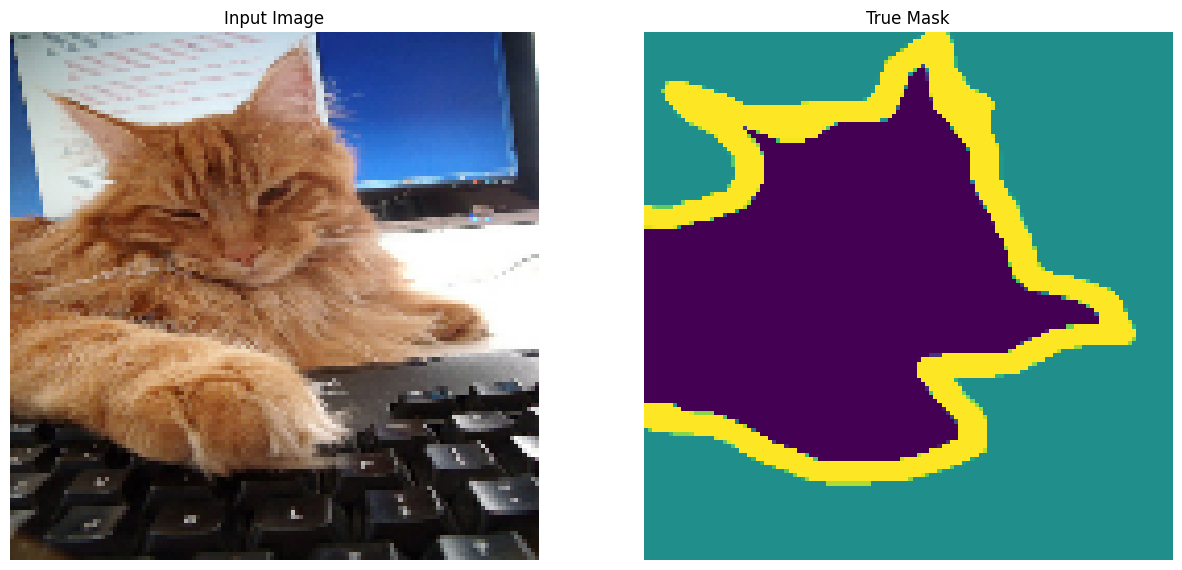

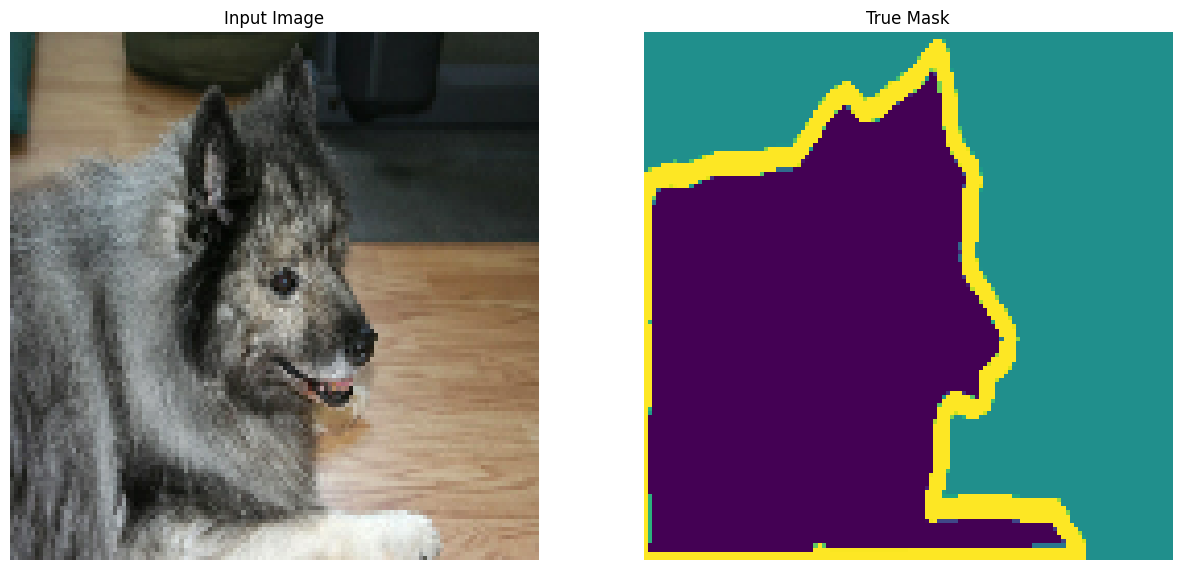

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    drop1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.1)(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.1)(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Dropout(0.1)(conv9)


    outputs = tf.keras.layers.Conv2DTranspose(
      filters=3, kernel_size=3, strides=1,
      padding='same', activation='softmax',dtype='float32')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (128, 128, 3)


In [ ]:
model = unet_model(input_shape)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['batch_normalization[0][0

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [ ]:
def show_predictions(num=5,model=model):
    for image,mask in test_batches.take(num):
      sample_image,sample_mask = image[0],mask[0]
      pred_mask = model.predict(image)
      display([sample_image, sample_mask, create_mask(pred_mask)])


In [ ]:
def add_sample_weights(image, label):
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)


  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:

early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    train_batches,
    epochs=30,
    validation_data=validation_batches,
    callbacks=[ early_stopping],
    use_multiprocessing = True,
    steps_per_epoch=STEPS_PER_EPOCH
)


Epoch 1/30
57/57 [==============================] - 138s 1s/step - loss: 0.7997 - accuracy: 0.6769 - val_loss: 1117.8215 - val_accuracy: 0.3069
Epoch 2/30
57/57 [==============================] - 89s 1s/step - loss: 0.5595 - accuracy: 0.7761 - val_loss: 22.0202 - val_accuracy: 0.4621
Epoch 3/30
57/57 [==============================] - 66s 1s/step - loss: 0.4970 - accuracy: 0.7981 - val_loss: 2.9380 - val_accuracy: 0.5789
Epoch 4/30
57/57 [==============================] - 66s 1s/step - loss: 0.4401 - accuracy: 0.8206 - val_loss: 4.8793 - val_accuracy: 0.5734
Epoch 5/30
57/57 [==============================] - 67s 1s/step - loss: 0.4121 - accuracy: 0.8319 - val_loss: 2.5069 - val_accuracy: 0.5917
Epoch 6/30
57/57 [==============================] - 66s 1s/step - loss: 0.3867 - accuracy: 0.8414 - val_loss: 2.6828 - val_accuracy: 0.5813
Epoch 7/30
57/57 [==============================] - 67s 1s/step - loss: 0.3614 - accuracy: 0.8522 - val_loss: 1.3305 - val_accuracy: 0.7048
Epoch 8/30
57/5

In [ ]:
model.evaluate(test_batches)

41/41 [==============================] - 13s 320ms/step - loss: 0.3324 - accuracy: 0.8744


[0.33241212368011475, 0.8744307160377502]

2/2 [==============================] - 1s 161ms/step


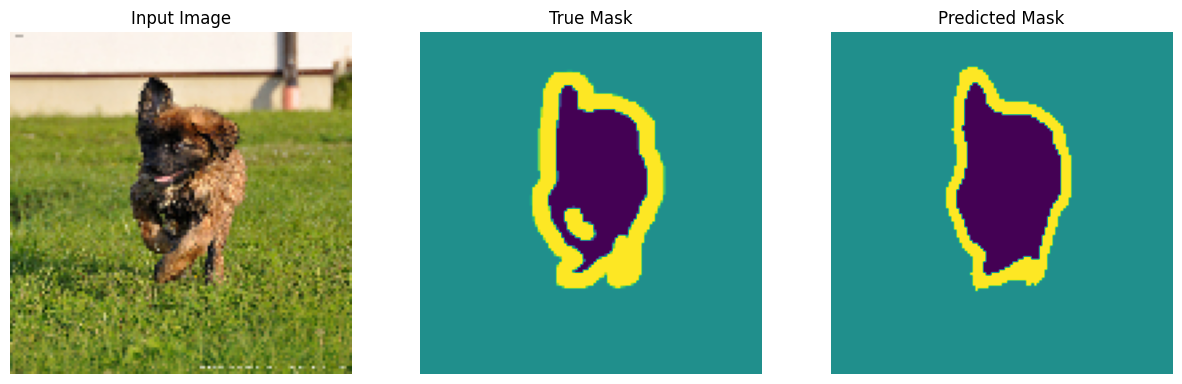

2/2 [==============================] - 0s 119ms/step


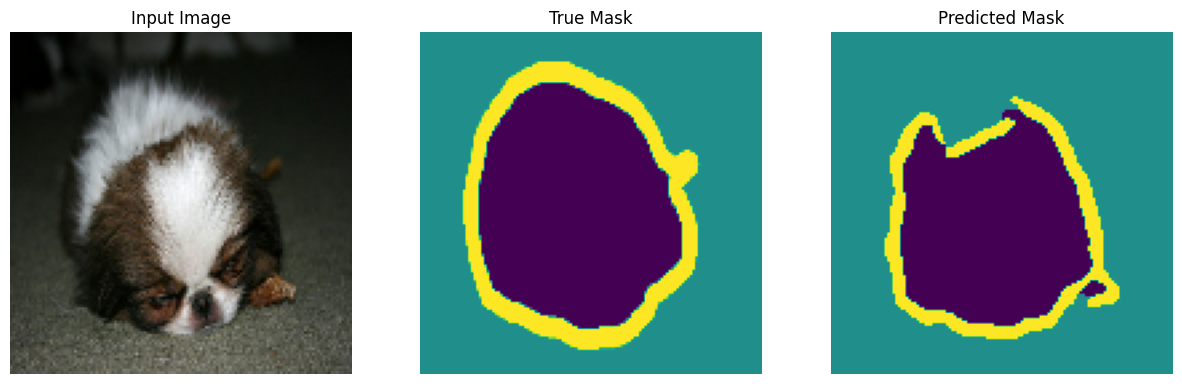

2/2 [==============================] - 0s 113ms/step


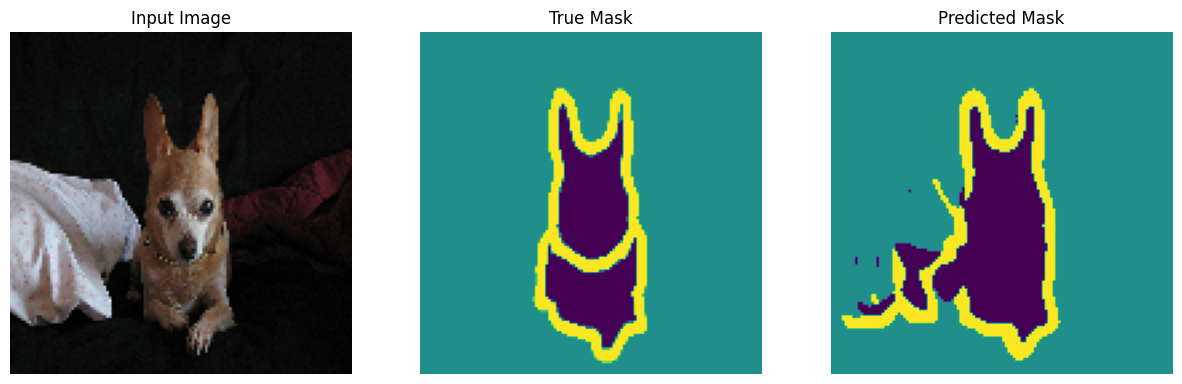

2/2 [==============================] - 0s 129ms/step


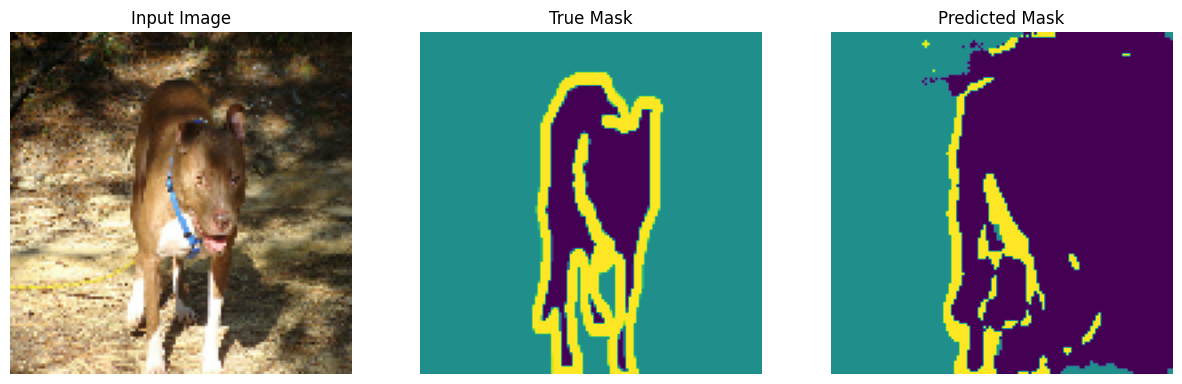

2/2 [==============================] - 0s 115ms/step


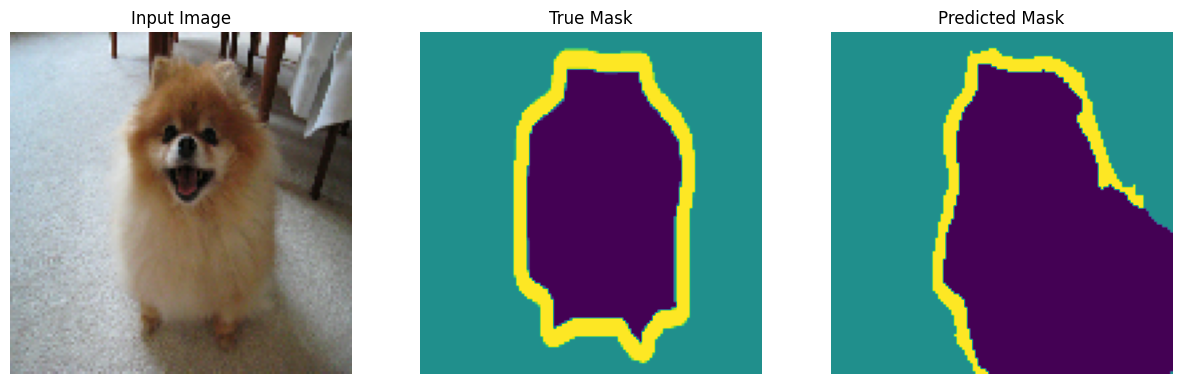

In [ ]:
show_predictions()


In [ ]:
initial_learning_rate = 0.001
decay_steps = 300
decay_rate = 1
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate, decay_steps, decay_rate,
  staircase=False)

In [ ]:
weighted_model = unet_model(input_shape)
weighted_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate_fn),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])


In [ ]:
early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=60,
    validation_data=validation_batches,
    callbacks=[ early_stopping],
    use_multiprocessing = True,
    steps_per_epoch=STEPS_PER_EPOCH
)



Epoch 1/60
115/115 [==============================] - 232s 1s/step - loss: 0.2692 - accuracy: 0.6906 - val_loss: 6.0987 - val_accuracy: 0.3323
Epoch 2/60
115/115 [==============================] - 149s 1s/step - loss: 0.1833 - accuracy: 0.7678 - val_loss: 2.3415 - val_accuracy: 0.5732
Epoch 3/60
115/115 [==============================] - 149s 1s/step - loss: 0.1562 - accuracy: 0.7977 - val_loss: 2.7347 - val_accuracy: 0.5728
Epoch 4/60
115/115 [==============================] - 149s 1s/step - loss: 0.1398 - accuracy: 0.8154 - val_loss: 1.9686 - val_accuracy: 0.5792
Epoch 5/60
115/115 [==============================] - 147s 1s/step - loss: 0.1284 - accuracy: 0.8280 - val_loss: 0.7581 - val_accuracy: 0.7515
Epoch 6/60
115/115 [==============================] - 148s 1s/step - loss: 0.1184 - accuracy: 0.8400 - val_loss: 0.5123 - val_accuracy: 0.7917
Epoch 7/60
115/115 [==============================] - 149s 1s/step - loss: 0.1112 - accuracy: 0.8482 - val_loss: 0.3942 - val_accuracy: 0.8464

1/1 [==============================] - 1s 982ms/step


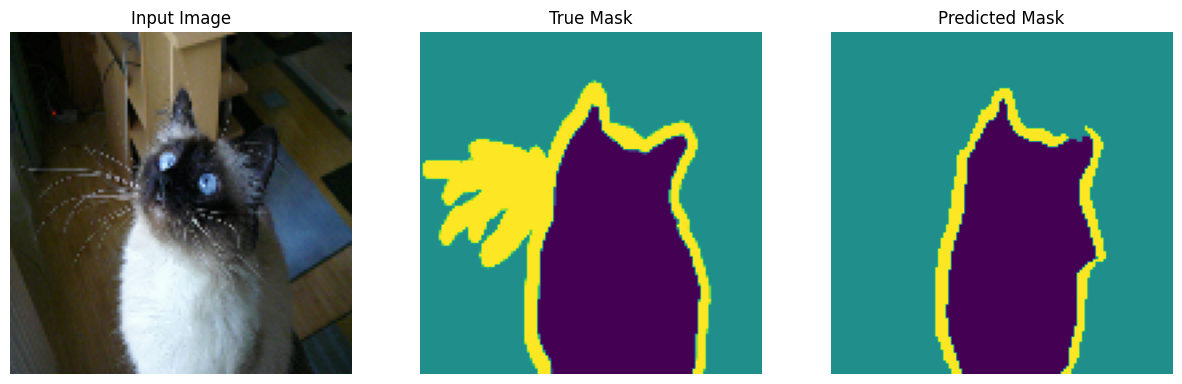

1/1 [==============================] - 0s 36ms/step


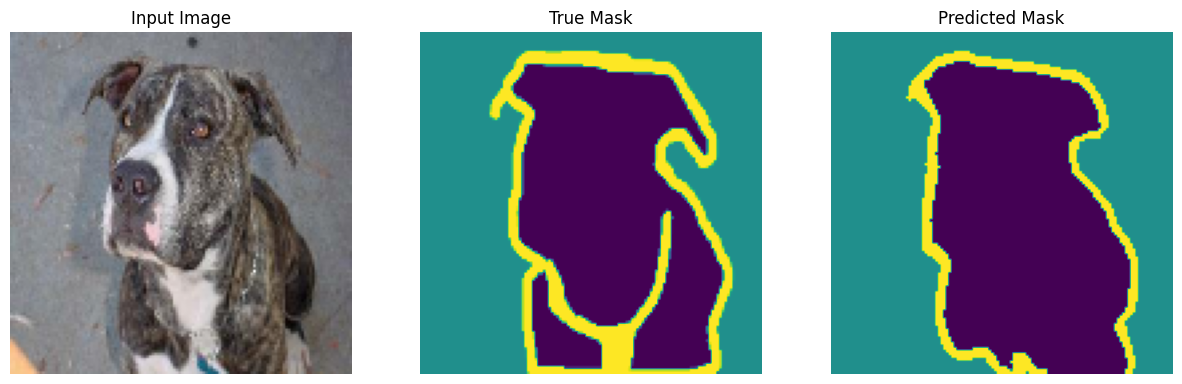

1/1 [==============================] - 0s 39ms/step


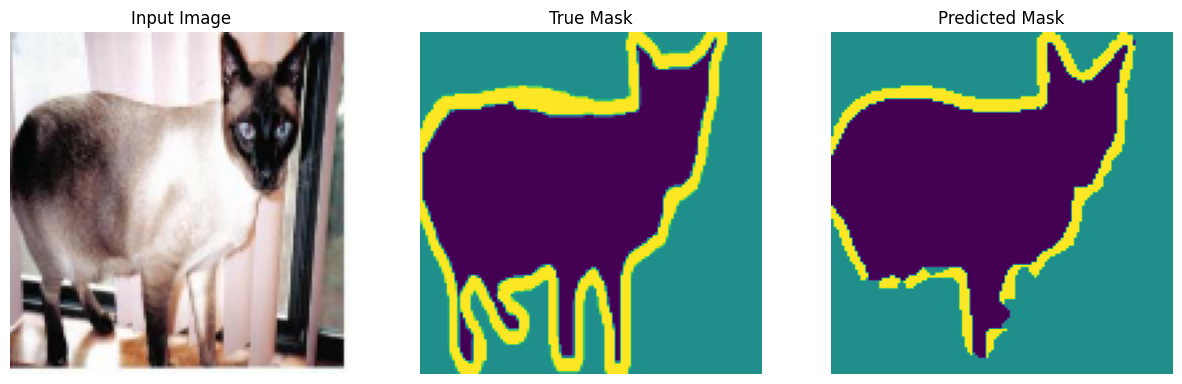

1/1 [==============================] - 0s 33ms/step


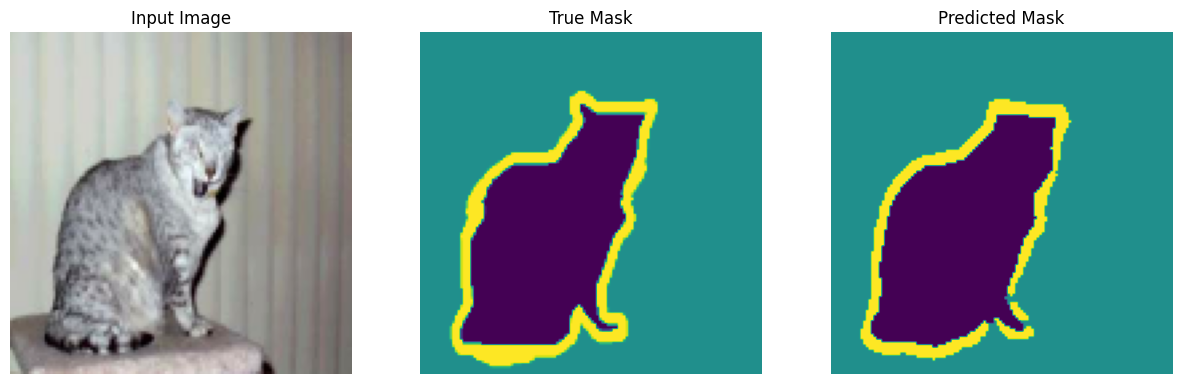

1/1 [==============================] - 0s 30ms/step


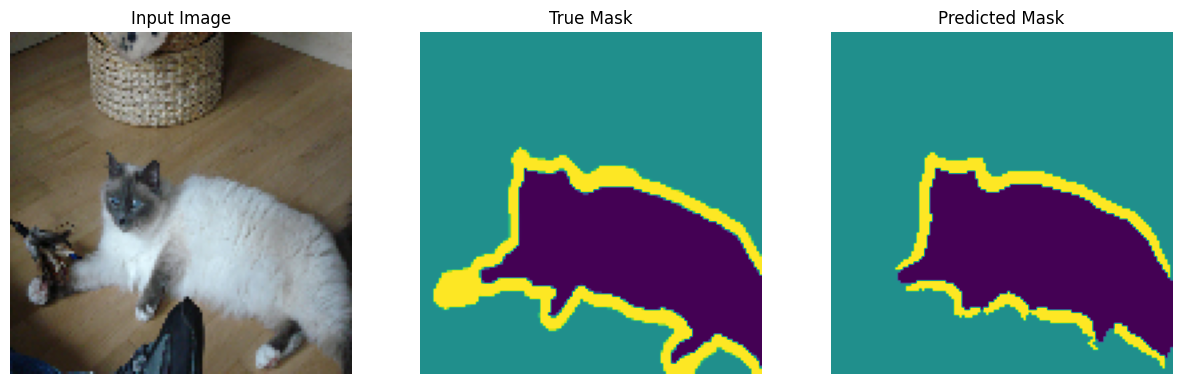

In [ ]:
show_predictions(model=weighted_model)

In [ ]:
weighted_model.evaluate(test_batches)

81/81 [==============================] - 30s 369ms/step - loss: 0.3290 - accuracy: 0.8844


[0.3290177285671234, 0.8843823671340942]

zmienić metryki, przeniść dropout, zdefiniować model w pętli

In [ ]:
# przeniesienie dropoutu przed przekazanie warstw do decodera

def unet_model2(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.1)(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.1)(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Dropout(0.1)(conv9)


    outputs = tf.keras.layers.Conv2DTranspose(
      filters=3, kernel_size=3, strides=1,
      padding='same', activation='softmax',dtype='float32')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (128, 128, 3)

In [ ]:
initial_learning_rate = 0.001
decay_steps = 600
decay_rate = 1
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate, decay_steps, decay_rate,
  staircase=False)

In [ ]:
weighted_model2 = unet_model2(input_shape)
weighted_model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate_fn),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

# ,tf.keras.metrics.IoU(num_classes=3, target_class_ids=[0,1,2])

In [ ]:
early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

weighted_model2.fit(
    train_batches.map(add_sample_weights),
    epochs=100,
    validation_data=validation_batches,
    callbacks=[ early_stopping],
    use_multiprocessing = True,
    steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/100
115/115 [==============================] - 231s 1s/step - loss: 0.2614 - accuracy: 0.6919 - val_loss: 21.8116 - val_accuracy: 0.3216
Epoch 2/100
115/115 [==============================] - 143s 1s/step - loss: 0.1699 - accuracy: 0.7830 - val_loss: 5.3061 - val_accuracy: 0.5728
Epoch 3/100
115/115 [==============================] - 143s 1s/step - loss: 0.1529 - accuracy: 0.8007 - val_loss: 1.9676 - val_accuracy: 0.5845
Epoch 4/100
115/115 [==============================] - 143s 1s/step - loss: 0.1330 - accuracy: 0.8235 - val_loss: 1.1924 - val_accuracy: 0.6773
Epoch 5/100
115/115 [==============================] - 143s 1s/step - loss: 0.1210 - accuracy: 0.8367 - val_loss: 0.7416 - val_accuracy: 0.7547
Epoch 6/100
115/115 [==============================] - 143s 1s/step - loss: 0.1115 - accuracy: 0.8482 - val_loss: 0.5296 - val_accuracy: 0.7929
Epoch 7/100
115/115 [==============================] - 143s 1s/step - loss: 0.1060 - accuracy: 0.8542 - val_loss: 0.4658 - val_accuracy

1/1 [==============================] - 1s 605ms/step


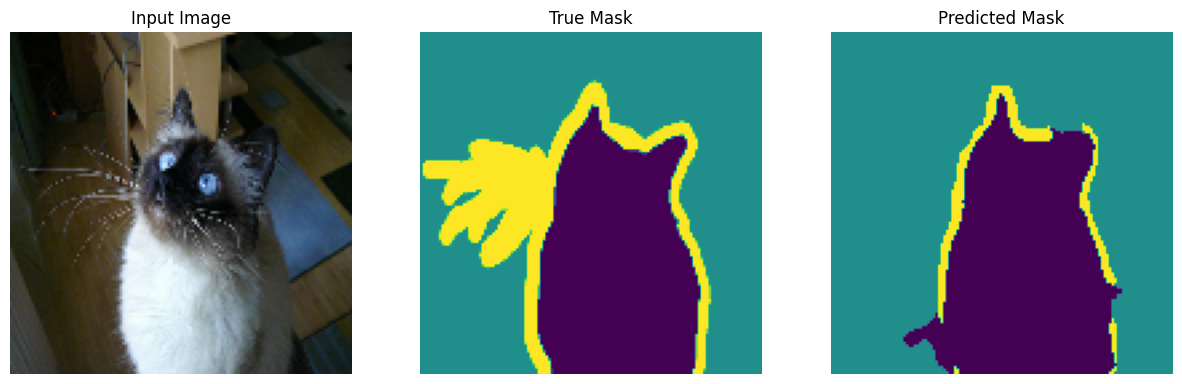

1/1 [==============================] - 0s 30ms/step


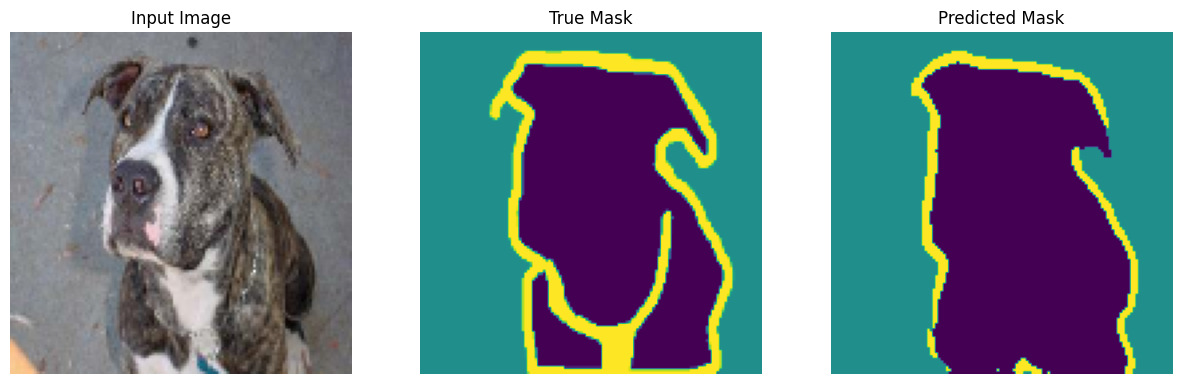

1/1 [==============================] - 0s 33ms/step


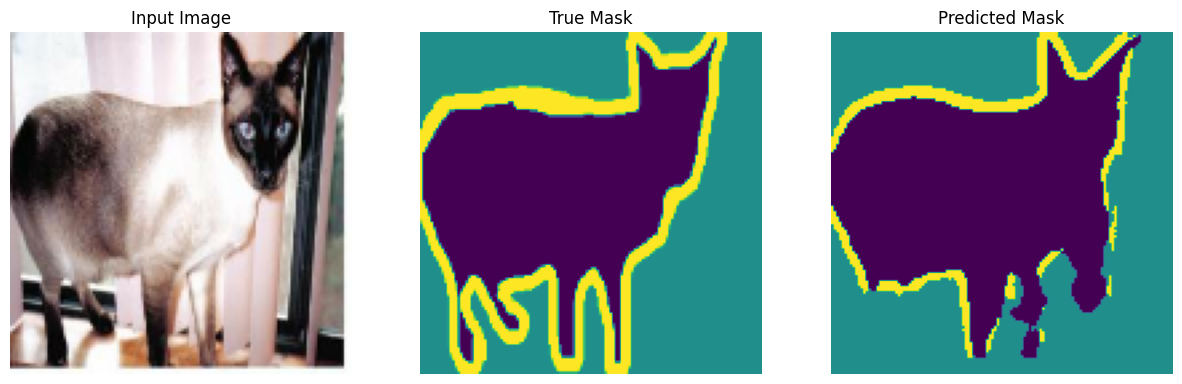

1/1 [==============================] - 0s 33ms/step


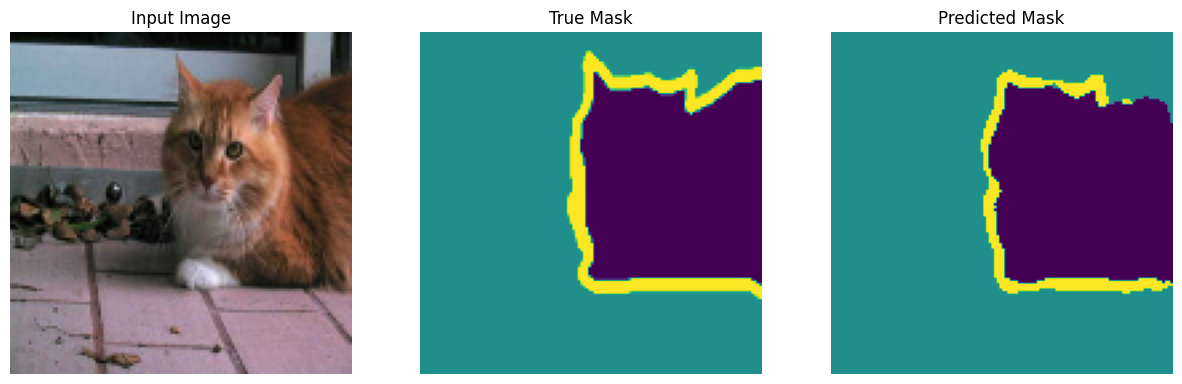

1/1 [==============================] - 0s 30ms/step


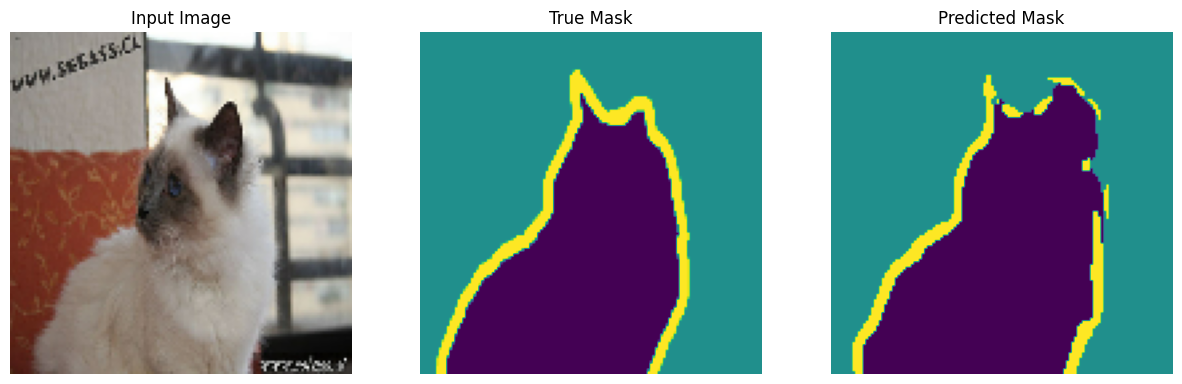

In [ ]:
show_predictions(model=weighted_model2)

In [ ]:
weighted_model2.evaluate(test_batches)

81/81 [==============================] - 29s 359ms/step - loss: 0.3183 - accuracy: 0.8865


[0.3182561993598938, 0.8864589929580688]

In [ ]:
weighted_model2.save("/home/models/weighted_model2.keras")

In [ ]:
# adding DepthwiseConv2D

from tensorflow.keras.layers import DepthwiseConv2D, ZeroPadding2D

def conv_block(inputs, filters, kernel_size=3, strides=1, padding='same', activation='relu',dropout=0.1):
    conv = Conv2D(filters, kernel_size, strides=strides, padding=padding, activation=activation)(inputs)
    # conv = BatchNormalization()(conv)
    # conv= ZeroPadding2D()(conv)
    # conv = DepthwiseConv2D(filters,kernel_size,padding=padding,activation=activation)(conv)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, kernel_size, strides=strides, padding=padding, activation=activation)(conv)
    conv = BatchNormalization()(conv)
    conv = Dropout(dropout)(conv)
    return conv

def unet_model3(input_shape):
    filters = [64, 128, 256, 512,1024]

    inputs = Input(input_shape)
    x = inputs

  # Encoder
    conv_blocks = []
    for i, f in enumerate(filters):
        x = conv_block(x, f)
        if i < len(filters) - 1:
            if x.shape[1] >= 2 and x.shape[2] >= 2:
                x = MaxPooling2D(pool_size=(2, 2))(x)
            else:
                print(f"Skipping pooling in block {i+1} due to insufficient input size")
        conv_blocks.append(x)


    # Decoder
    for i, f in reversed(list(enumerate(filters[:-1]))):
        print(x.shape)
        print(conv_blocks[i].shape)
        x = concatenate([conv_blocks[i], x], axis=3)
        x = Conv2DTranspose(f, 2, strides=(2, 2), padding='same')(x)
        x = conv_block(x, f)

    # Output layer
    outputs = tf.keras.layers.Conv2DTranspose(
    filters=3, kernel_size=2, strides=1,
    padding='same', activation='softmax',dtype='float32')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
initial_learning_rate = 0.001
decay_steps = 1200
decay_rate = 1
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate, decay_steps, decay_rate,
  staircase=False)

In [ ]:
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

NameError: name 'tf' is not defined

In [ ]:
weighted_model3 = unet_model3(input_shape)
weighted_model3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate_fn),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
    # options=run_opts
    )
weighted_model3.summary()

(None, 8, 8, 1024)
(None, 8, 8, 512)
(None, 16, 16, 512)
(None, 16, 16, 256)
(None, 32, 32, 256)
(None, 32, 32, 128)
(None, 64, 64, 128)
(None, 64, 64, 64)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 128, 128, 64)         256       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                   

In [ ]:
early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

weighted_model3.fit(
    train_batches.map(add_sample_weights),
    epochs=100,
    validation_data=validation_batches,
    callbacks=[ early_stopping],
    use_multiprocessing = True,
    steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/100
115/115 [==============================] - 215s 1s/step - loss: 0.2565 - accuracy: 0.7058 - val_loss: 34.8957 - val_accuracy: 0.3497
Epoch 2/100
115/115 [==============================] - 144s 1s/step - loss: 0.1675 - accuracy: 0.7860 - val_loss: 3.4707 - val_accuracy: 0.5729
Epoch 3/100
115/115 [==============================] - 144s 1s/step - loss: 0.1407 - accuracy: 0.8138 - val_loss: 1.7482 - val_accuracy: 0.5955
Epoch 4/100
115/115 [==============================] - 144s 1s/step - loss: 0.1307 - accuracy: 0.8252 - val_loss: 0.9251 - val_accuracy: 0.6987
Epoch 5/100
115/115 [==============================] - 144s 1s/step - loss: 0.1204 - accuracy: 0.8377 - val_loss: 0.6033 - val_accuracy: 0.7923
Epoch 6/100
115/115 [==============================] - 144s 1s/step - loss: 0.1121 - accuracy: 0.8471 - val_loss: 0.5329 - val_accuracy: 0.7929
Epoch 7/100
115/115 [==============================] - 144s 1s/step - loss: 0.1057 - accuracy: 0.8540 - val_loss: 0.5761 - val_accuracy

In [ ]:
weighted_model3.save("/home/models/weighted_model3.keras")

1/1 [==============================] - 1s 1s/step


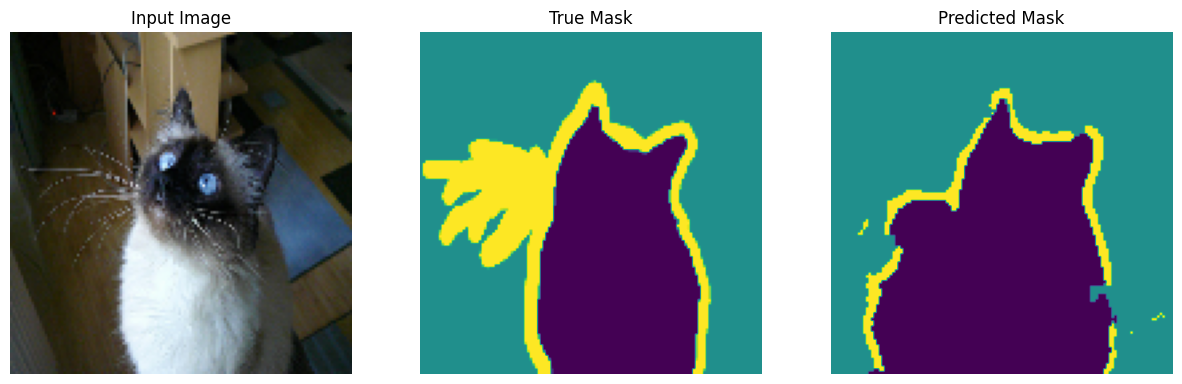

1/1 [==============================] - 0s 33ms/step


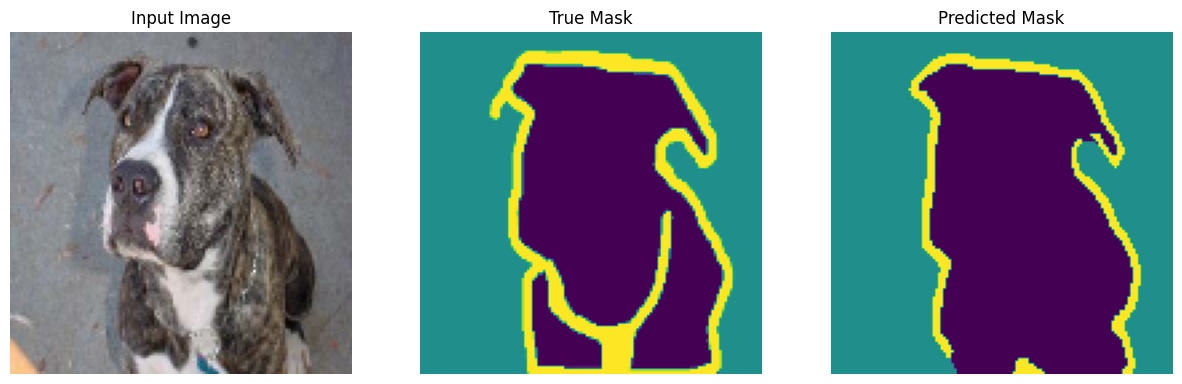

1/1 [==============================] - 0s 32ms/step


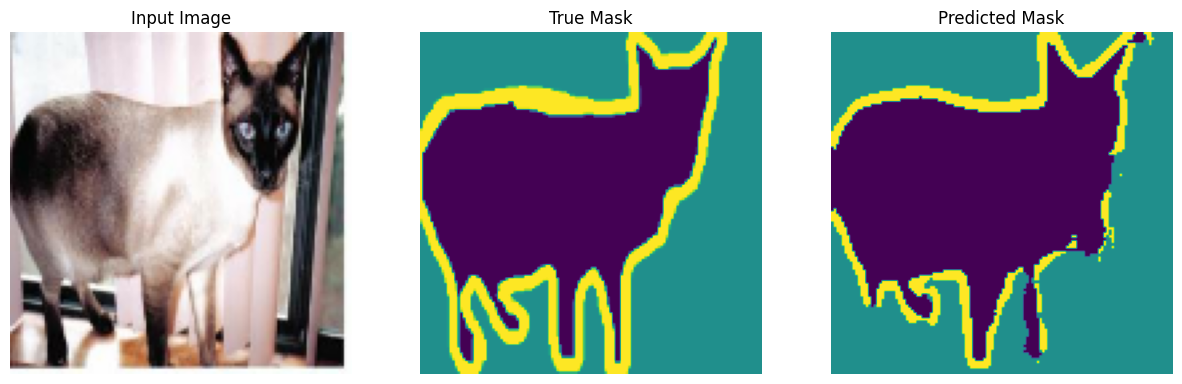

1/1 [==============================] - 0s 32ms/step


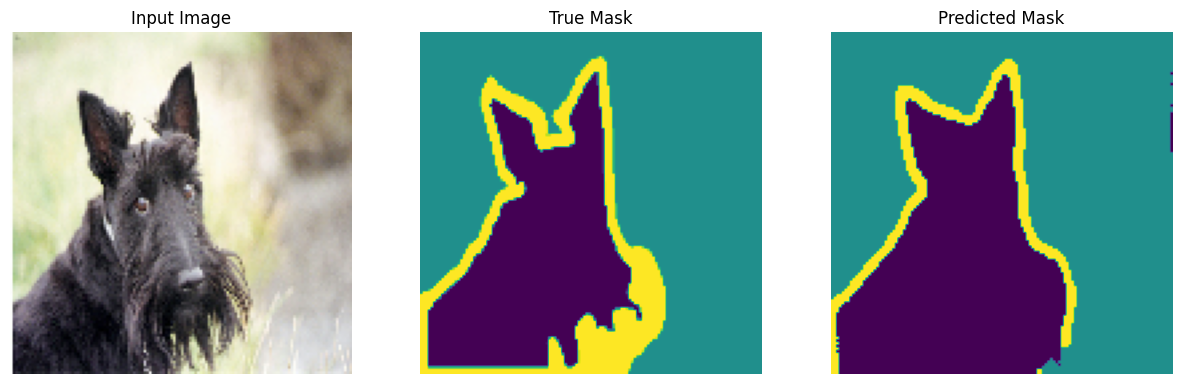

1/1 [==============================] - 0s 32ms/step


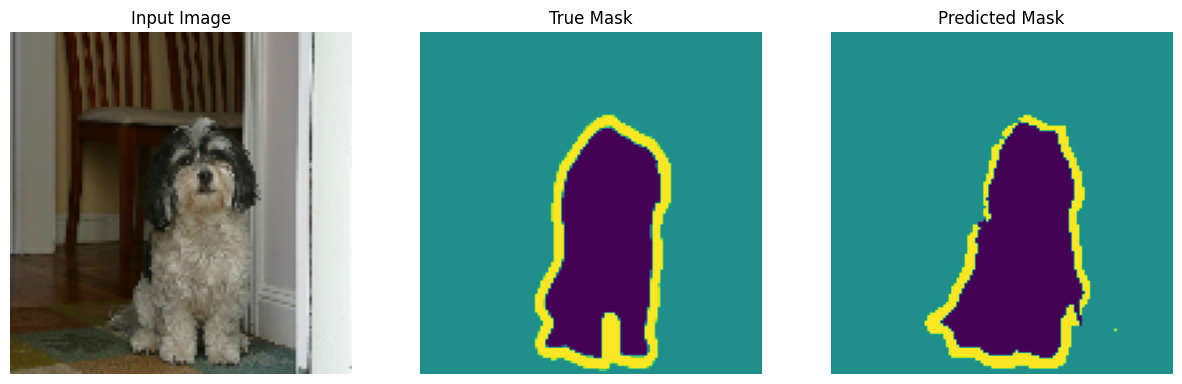

In [ ]:
show_predictions(model=weighted_model3)

In [ ]:
weighted_model3.evaluate(test_batches)

81/81 [==============================] - 28s 343ms/step - loss: 0.2986 - accuracy: 0.8907


[0.2986066937446594, 0.8906946182250977]

In [ ]:
from numba import cuda
device = cuda.get_current_device()




In [ ]:
device.reset()

In [ ]:
num_classes=3

weighted_model4 = unet_model3(input_shape)
weighted_model4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate_fn),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.IoU(num_classes, range(num_classes), sparse_y_pred=False, name='IoU')], \
    weighted_metrics=['accuracy', tf.keras.metrics.IoU(num_classes, range(num_classes), sparse_y_pred=False, name='IoU')])

weighted_model4.summary()

(None, 8, 8, 1024)
(None, 8, 8, 512)
(None, 16, 16, 512)
(None, 16, 16, 256)
(None, 32, 32, 256)
(None, 32, 32, 128)
(None, 64, 64, 128)
(None, 64, 64, 64)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_82 (Conv2D)          (None, 128, 128, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_82 (Ba  (None, 128, 128, 64)         256       ['conv2d_82[0][0]']           
 tchNormalization)                                                                                
                                   

In [ ]:
early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

weighted_model4.fit(
    train_batches.map(add_sample_weights),
    epochs=100,
    validation_data=validation_batches.map(add_sample_weights),
    callbacks=[ early_stopping],
    use_multiprocessing = True,
    steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/100
115/115 [==============================] - 145s 1s/step - loss: 0.0882 - accuracy: 0.8748 - IoU: 0.6645 - weighted_accuracy: 0.9036 - weighted_IoU: 0.6754 - val_loss: 0.4261 - val_accuracy: 0.8376 - val_IoU: 0.6083 - val_weighted_accuracy: 0.8376 - val_weighted_IoU: 0.6083
Epoch 2/100
115/115 [==============================] - 145s 1s/step - loss: 0.0839 - accuracy: 0.8789 - IoU: 0.6734 - weighted_accuracy: 0.9070 - weighted_IoU: 0.6835 - val_loss: 0.3402 - val_accuracy: 0.8631 - val_IoU: 0.6441 - val_weighted_accuracy: 0.8631 - val_weighted_IoU: 0.6441
Epoch 3/100
115/115 [==============================] - 145s 1s/step - loss: 0.0818 - accuracy: 0.8825 - IoU: 0.6804 - weighted_accuracy: 0.9103 - weighted_IoU: 0.6901 - val_loss: 0.3399 - val_accuracy: 0.8652 - val_IoU: 0.6522 - val_weighted_accuracy: 0.8652 - val_weighted_IoU: 0.6522
Epoch 4/100
115/115 [==============================] - 145s 1s/step - loss: 0.0794 - accuracy: 0.8844 - IoU: 0.6849 - weighted_accuracy: 0.911

1/1 [==============================] - 0s 112ms/step


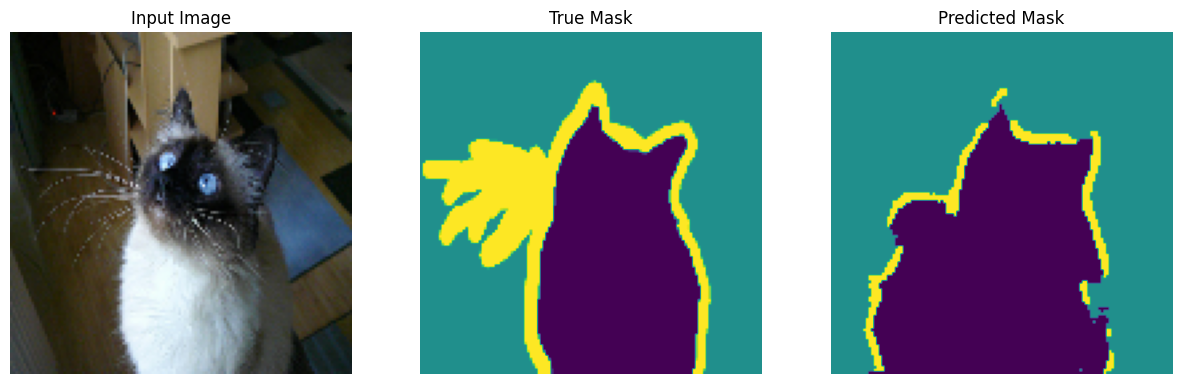

1/1 [==============================] - 0s 35ms/step


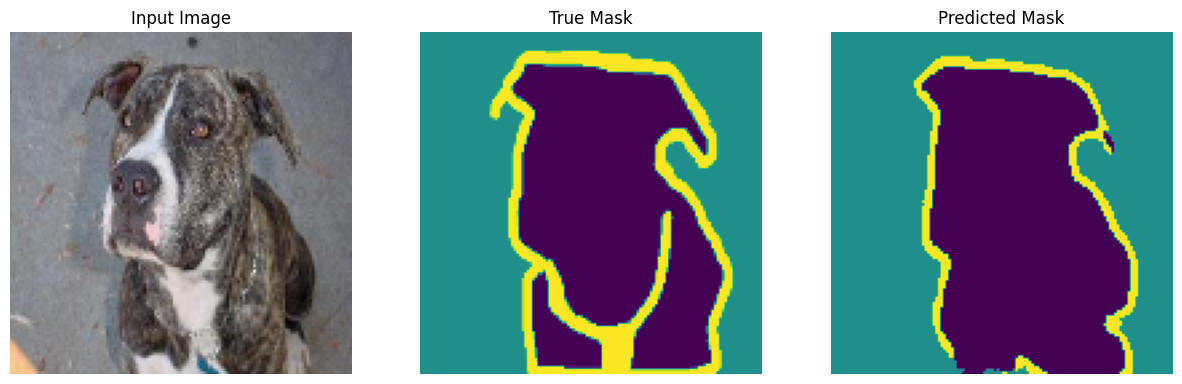

1/1 [==============================] - 0s 33ms/step


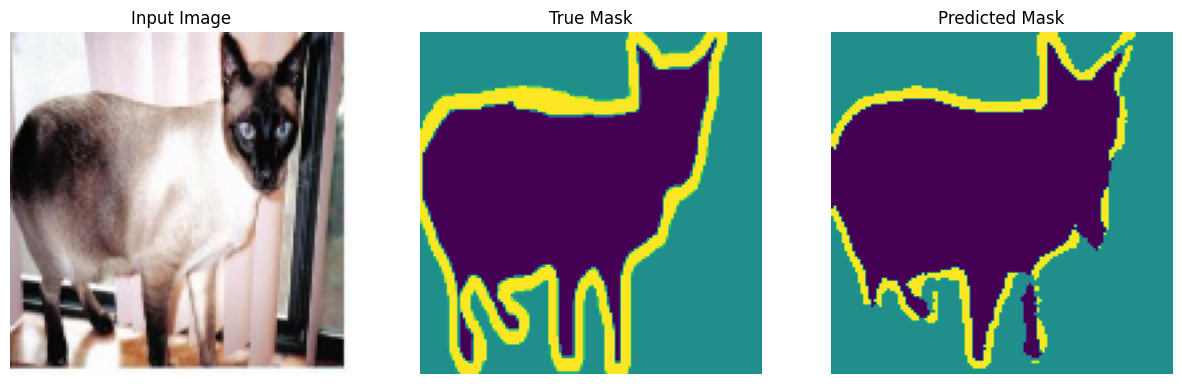

1/1 [==============================] - 0s 31ms/step


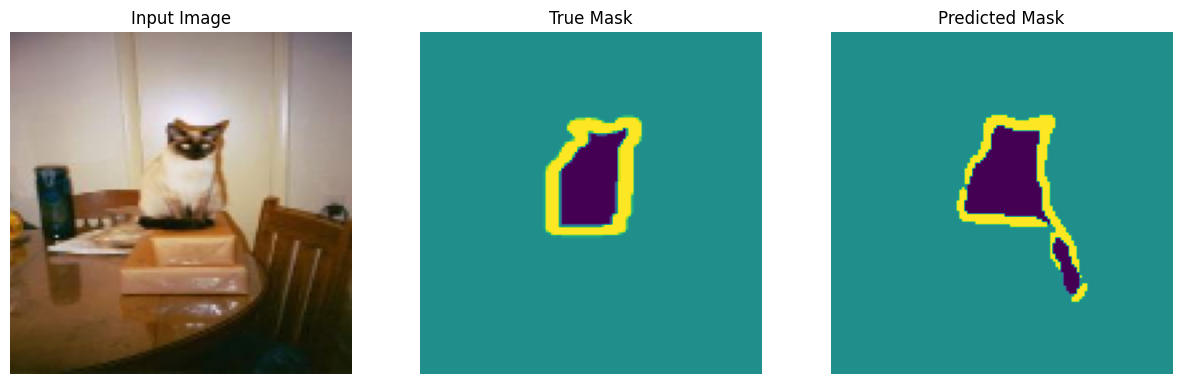

1/1 [==============================] - 0s 44ms/step


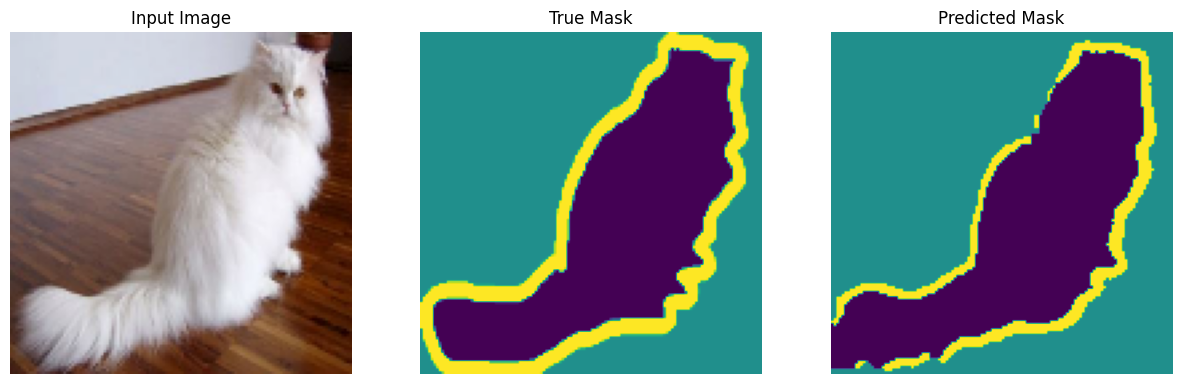

In [ ]:
show_predictions(model=weighted_model3)

In [ ]:
weighted_model3.evaluate(test_batches)

81/81 [==============================] - 23s 284ms/step - loss: 0.3022 - accuracy: 0.8878


[0.30224284529685974, 0.8878083229064941]

Metryki zostały zaktualizowane póżniej i po konsultacji z prowadzącym metryki wcześniejszych treningów nie były zaktualizowane ze względu na oszczędność prądu i czasu